# Resampling methods: permutation tests

## Lecture plan

- CSS 100 in context: where are we now?
- Review: hypothesis testing.
   - Are these two samples from *different populations*?
   - The traditional approach.
- An alternative approach: **permutation tests**.  
   - Explanation, and connection to **Central Limit Theorem**.
- Permutation tests in action.

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Where are we now?

> **CSS 100** equips students with *advanced techniques* for processing, modeling, and analyzing social science data of various kinds.

- Week 1: *Object-oriented programming*.
- Weeks 2-3: Basic tools for using *text as data*.  
- Weeks 4-7: Advanced *statistical tools* for answering research questions.
- Weeks 8-10: The deep learning revolution.

We're in **week 4**: shifting from processing text to working with numbers.

## Review: Hypothesis testing

In CSS, we frequenly want to **test some hypothesis**.

- Was a new vaccine successful in preventing infections?  
- Does the minimum wage affect the unemployment rate?  
- Are people faster to recognize *short* words than *long* words?

In each case, we must *operationalize* this question in terms of **statistical distributions**.

### Distributions in practice: An example

*Example*: Do people recognize `Short` words faster than `Long` words?

In [36]:
df_example = pd.read_csv("data/resampling/example.csv")
df_example.sample(5)

,Length,Reaction Time
49,Short,196.776133
135,Long,326.011964
57,Short,183.378874
17,Short,345.590632
166,Long,206.145618


#### Check-in

Make a visualization comparing `Long` vs. `Short` words in terms of their `Reaction Time`. What do you notice?

In [37]:
### Your code here

#### An example visualization

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


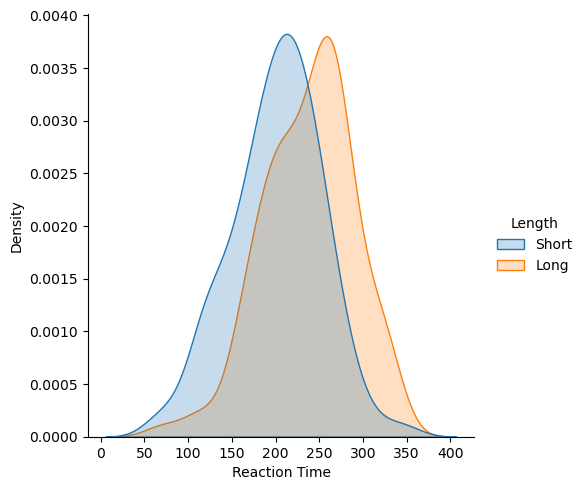

In [38]:
sns.displot(data = df_melted, x = "Reaction Time", 
            hue = "Length", kind = 'kde', fill = True)

### Are two distributions *different*?

- It *seems* like those distributions are different.
   - On average, `Reaction Time` larger for `Long` than `Short` words.
- But how do we know this difference is "real", as opposed to **sampling error**?

In [41]:
df_example.groupby("Length").mean()

,Reaction Time
Length,
Long,237.448297
Short,201.231160


### Review: samples, populations, and sampling error

- A **population** is a set of *potential* observations you're interested in.
- We can't survey an entire population, so we rely on **samples**.
  - A **sample** is an *actual* set of observations drawn ("sampled") from the population.
- Even random, representative samples will be subject to **sampling error**.  

> **Sampling error** means that *statistics* calculated on a sample (e.g., `mean`) will rarely (if ever) be identical to the underlying *population parameter*.

*Why might sampling error pose a problem for asking whether two distributions are different?*

### The challenge of sampling error

*Question* Are `Reaction Time`s for `Long` and `Short` words actually different?

- One possibility is **yes**: they are drawn from different "populations".  
  - This is consistent with different *means*. 
- But another possibility is **no**: they're drawn from the same population, with some sampling error.
  - This is *also* consistent with different *means*.
  
**We need some way to measure the difference we'd expect from *sampling error* alone.**

### Hypothesis tests: the traditional approach

> A **statistical hypothesis test**, such as a *t-test*, compares some *test statistic* (e.g., *t-statistic*) to a **null distribution**.

- The **null distribution** is the set of $t$-values you'd expect if the two samples were in fact drawn from the same population.
- We can calculate the *probability value* ($p$-value) of our *actual* $t$-value occurring in that null distribution.  
- If $p < .05$, we **reject the null hypothesis** that the samples came from the same distribution.

### Visualizing the null distribution

- Let's assume *degrees of freedom* (`df`) is 10.
- Values closer to 0 are more likely; larger values are less likely.

Text(0, 0.5, 'Probability')

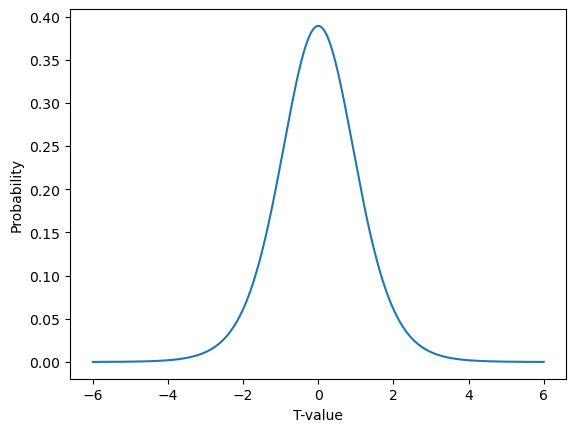

In [60]:
X = np.linspace(-6, 6, 1000)
t_distribution = ss.t.pdf(X, 10)
plt.plot(X, t_distribution)
plt.xlabel("T-value")
plt.ylabel("Probability")

### t-test in action

- In this case, we'd want to use the **independent samples t-test** (`scipy.stats.ttest_ind`).  
- The `statistic` is larger than we'd expect by chance, so the `pvalue` is small.

In [61]:
import scipy.stats as ss

In [62]:
short = df_example[df_example['Length']=='Short']['Reaction Time']
long = df_example[df_example['Length']=='Long']['Reaction Time']
result = ss.ttest_ind(long, short)
result

TtestResult(statistic=4.983544613500152, pvalue=1.3583270188465312e-06, df=198.0)

### Making it concrete

- Our *actual* t-value is very unlikely under the null distribution.

Text(0, 0.5, 'Probability')

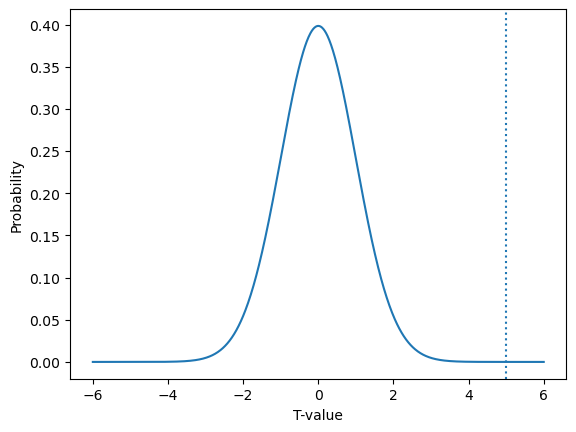

In [63]:
t_distribution = ss.t.pdf(X, 198)
plt.plot(X, t_distribution)
plt.axvline(result.statistic, linestyle = "dotted")
plt.xlabel("T-value")
plt.ylabel("Probability")

### Limitations of traditional hypothesis tests

- Traditional hypothesis tests are great, but also **limited**.
- Traditional tests have strong **assumptions**.
   - Assume *roughly equal variance* across samples.
   - Assume specific *shape* of *sampling distribution*, e.g., $\chi^2$ or $t$.
   - Assume specific *test statistic*.
- Often, our actual data don't satisfy these assumptions.
- We'd like a more **flexible** approach.

## Permutation tests: an alternative approach

> A **permutation test** compares some actual *test statistic* to the distribution of test statistics one would expect if data were **randomly shuffled** (i.e., **permuted**).

- Conceptually, very similar to traditional hypothesis tests.  
- Main difference: we don't *assume* a specific test statistic or null distribution.

**Key insight**: Use the data itself to create your null distribution!

### Advantages of permutation tests

- More **flexible**: can be used with any test statistic.  
- Fewer **assumptions**: doesn't require normality or equal variance.  
- More **robust**: tends to be more robust to outliers and skewed distributions.  
   - The shuffles already account for structure of the data.
- More **applicable**: because of flexibility, can be used with more datasets that don't satisfy assumptions of traditional tests.
- More **interpretable**: personally, I think they are easier to interpret and explain!

### Permutation tests: step-by-step

1. Calculate the desired **test statistic** for your original samples (e.g., `Long` vs. `Short`). 
2. Now, *shuffle* the labels of your dataset randomly (e.g., switch up `Long` and `Short`).  
3. Calculate test statistic for this new, shuffled dataset.  
4. Repeat steps 2-3 many times (e.g., 1000x or more) to form the **permutation distribution**. 
5. Compare the result from step (1) to step (4). 
6. What *proportion* of permuted samples resulted in a test statistic larger than the actaul test statistic?

### Connection to *Central Limit Theorem*

> The **Central Limit Theorem** (CLT) states that the distribution of sample means approximates a normal distribution, regardless of the underlying distribution.

- The *empirical null distribution* resulting from permutation tests also often resembles a normal distribution.  
- This allows for easier comparison of our *actual* test statistic to the null distribution.

## Permutation tests in action

Now, let's apply permutation tests to our original dataset.

In [64]:
df_example.head(2)

,Length,Reaction Time
0,Short,216.800352
1,Short,244.284309


### Step 1: Calculate desired test statistic

- For simplicity, let's compare the *difference in mean `Reaction Time` across samples.  

In [77]:
means = df_example.groupby("Length").mean('Reaction Time')
true_diff = means['Reaction Time']['Long'] - means['Reaction Time']['Short']
true_diff

36.21713709546259

### Step 2: Shuffle dataset labels

- We can use `np.random.permutation` to shuffle an `np.array`. 

In [78]:
df_example['Shuffled_length'] = np.random.permutation(df_example['Length'].values)
df_example.head(3)

,Length,Reaction Time,shuffled,Shuffled_length
0,Short,216.800352,Short,Long
1,Short,244.284309,Short,Long
2,Short,246.485614,Short,Short


### Step 3: Calculate test statistic for shuffled distribution.

- Now, let's calculate the *mean difference* for these new, shuffled values.

In [79]:
means = df_example[['Shuffled_length', 'Reaction Time']].groupby("Shuffled_length").mean()
random_diff = means['Reaction Time']['Long'] - means['Reaction Time']['Short']
random_diff

-12.370000309266032

### Step 4: Repeat steps 2-3 many times

- Now, let's repeat steps 2-3 1000x to create our **null distribution**.

In [83]:
null_dist = []
num_permutations = 1000
for i in range(0, num_permutations):
    df_example['Shuffled_length'] = np.random.permutation(df_example['Length'].values)
    means = df_example[['Shuffled_length', 'Reaction Time']].groupby("Shuffled_length").mean()
    random_diff = means['Reaction Time']['Long'] - means['Reaction Time']['Short']
    null_dist.append(random_diff)

In [84]:
len(null_dist)

1000

### Step 5: Compare our actual test statistic to the null distribution

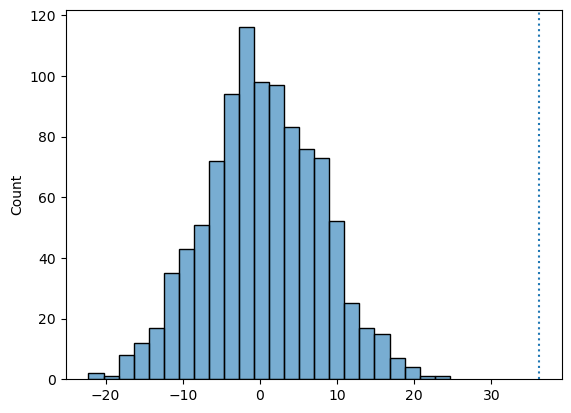

In [90]:
sns.histplot(x = null_dist, alpha = .6)
plt.axvline(x = true_diff, linestyle = "dotted")

### Step 6: Calculate a $p$-value

- What *proportion* of our null distribution values is at least as large as our test statistic?  
- Here, zero percent!

In [93]:
count = [i for i in null_dist if i > true_diff]
len(count) / len(null_dist)

0.0

### Recap: permutation tests

- We compared the **actual difference in means** to the distribution of differences obtained if labels were **randomly shuffled**.  
  - This is called a *permutation test*.  
- Key **advantages**:
  - We could use any test statistic instead of `mean`, e.g., `median`.  
  - We don't make strong assumptions about shape or variance of our samples.  
- We can also apply this to other questions, like **regression coefficients**. Very flexible approach!

## Lecture wrap-up

- Much of statistics is about asking whether some *numerical difference* is "real".  
   - This is critical for many questions in CSS.  
- One approach to this is to run a traditional *hypothesis test*, like a t-test.
   - These approaches tend to have **strong assumptions**.
- A more flexible approach is to run a **permutation test**.
   - Relies on structure of data to compare real test statistic to test statistics from *permutations*.
   - Fewer assumptions, wider applicability.
- Extremely powerful approach: this is just the start!